In [1]:
from keras.layers import Input, Dense,Dropout, Flatten,Lambda
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split as tts
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.utils import np_utils,plot_model
from keras.layers.convolutional import Convolution2D,MaxPooling2D,Conv2D
from keras import backend as K
from keras.losses import categorical_hinge,categorical_crossentropy
import tensorflow as tf

Using TensorFlow backend.
/home/slcf/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.datasets import fashion_mnist as mnist
import numpy as np
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
## Make the input image flat
n_features = np.prod(x_train.shape[1:])
xtrain = x_train.reshape((len(x_train),n_features))
xtest = x_test.reshape((len(x_test),n_features))

In [4]:
### Construct Classifier
X_train = xtrain.reshape(xtrain.shape[0],28,28,1)
Y_train = np_utils.to_categorical(y_train)
X_test = xtest.reshape(xtest.shape[0],28,28,1)
Y_test = np_utils.to_categorical(y_test)
#Y_test = y_test
## in this example, we used sparse cross entropy loss!
num_classes = 10
Xtr, Xval, Ytr, Yval = tts(X_train,Y_train,test_size = 0.3)
#Xtr, Xval, Ytr, Yval = tts(Xtr,Ytr,test_size = 0.3)

In [5]:
import sys
sys.path.append('../')
from mnist_clf import *

In [6]:
mnist_cnn = Mnist_CNN(X_train,Y_train)

In [7]:
#mnist_cnn.train("../logs/fashion_mnist_CNN_clf.ckpt")
mnist_cnn.restore('../logs/fashion_mnist_CNN_clf.ckpt')

INFO:tensorflow:Restoring parameters from ../logs/fashion_mnist_CNN_clf.ckpt
Success!


In [8]:
mnist_cnn.accuracy_score(X_test,Y_test)

0.88510001

In [9]:
print(Y_test.shape)
X_test = xtest.reshape(xtest.shape[0],28,28,1)
Y_test = np_utils.to_categorical(y_test)
print(X_test.shape)

(10000, 10)
(10000, 28, 28, 1)


In [10]:
_,xtest_n = corrupt(X_test,scale =0.3,noise_type = 'peppSalt')
test_acc = mnist_cnn.sess.run(mnist_cnn.accuracy,feed_dict = {mnist_cnn.eval_imgs:xtest_n,mnist_cnn.labels_eval:Y_test})
print(test_acc)

0.2456


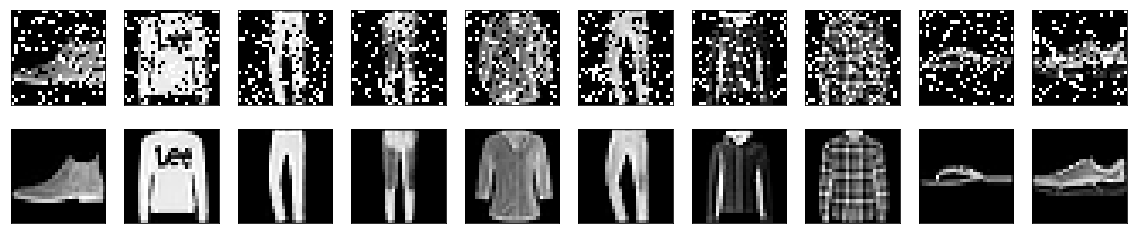

In [11]:
n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(xtest_n[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [12]:
mnist_cnn.targeted_attack(X_test,Y_test)

AttributeError: 'Mnist_CNN' object has no attribute 'labelse_adv'